In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pong

import tensorflow as tf
import matplotlib.pyplot as plt
import pydot

tf.enable_eager_execution()

tf.__version__

'1.14.0'

In [3]:
SEQ_LEN = 128
W, H = 50, 50

data_input = lambda: pong.games_generator(W, H, SEQ_LEN)

make_dataset = lambda bs: tf.data.Dataset.from_generator(
    data_input,
    output_types=((tf.float32, tf.float32), (tf.float32, tf.bool)),
).batch(bs)

In [4]:
X, Y = list(make_dataset(64).take(1))[0]
(directions, controls), (frames, game_over) = X, Y

directions.shape, controls.shape, frames.shape, game_over.shape

W1004 02:09:02.799476 139620787255104 deprecation.py:323] From /home/izpc/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


(TensorShape([Dimension(64)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(2)]),
 TensorShape([Dimension(64), Dimension(128), Dimension(50), Dimension(50)]),
 TensorShape([Dimension(64), Dimension(128)]))

In [14]:
def mk_model():
    direction_inp = tf.keras.layers.Input(shape=(1), name='dir_input')
    user_input = tf.keras.layers.Input(shape=(SEQ_LEN, 2), name='user_input')

    hidden_direction = tf.keras.layers.Dense(
        100,
        name='hidden_dir_input',
    )(direction_inp)

    activation_direction = tf.keras.layers.Dense(
        100,
        name='activation_dir_input',
    )(direction_inp)
    
    transformed_user_input = tf.keras.layers.LSTM(
        100,
        return_sequences=True,
        name='transformed_user_inpuit'
    )(user_input)

    x = tf.keras.layers.LSTM(
        100,
        return_sequences=True,
        name='x'
    )(
        transformed_user_input,
        initial_state=[activation_direction, hidden_direction]
    )

    x = tf.keras.layers.LSTM(100, return_sequences=True, name='x2')(x)
    x = tf.keras.layers.LSTM(100, return_sequences=True, name='x3')(x)

    frames = tf.keras.layers.Dense(W * H)(x)
    frames = tf.reshape(frames, (-1, SEQ_LEN, W, H), name='frames')
    
    game_over = tf.keras.layers.Dense(1)(x)
    game_over = tf.squeeze(game_over, [-1], name='game_over')

    model = tf.keras.Model([direction_inp, user_input], [frames, game_over])
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [15]:
model = mk_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 128, 2)]     0                                            
__________________________________________________________________________________________________
dir_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
transformed_user_inpuit (LSTM)  (None, 128, 100)     41200       user_input[0][0]                 
__________________________________________________________________________________________________
activation_dir_input (Dense)    (None, 100)          200         dir_input[0][0]                  
____________________________________________________________________________________________

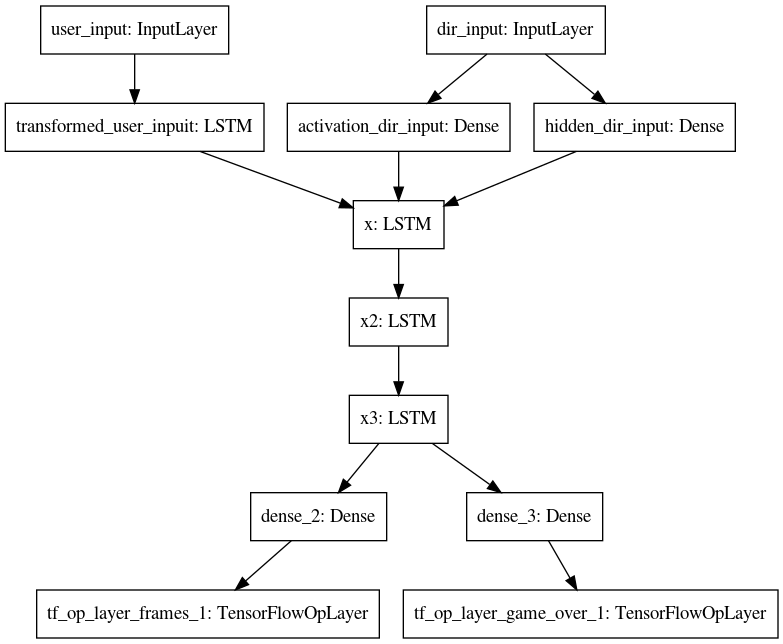

In [25]:
tf.keras.utils.plot_model(model, to_file='model.png')

In [8]:
def plot_at_frame(frames):
    frames, gos = model.predict([directions, controls])
    plt.imshow(frames[0, frame], cmap='seismic')

In [20]:
def plot_pairwise_frames(frame_nums):
    X, Y = list(make_dataset(1).take(1))[0]
    (directions, controls), (frames, game_over) = X, Y
    pred_frames, _ = model.predict([directions, controls])

    plot_size = 2
    num_imgs = len(frame_nums)
    fig, axs = plt.subplots(2, num_imgs, figsize=(plot_size * num_imgs, plot_size * 2))

    for i, f in enumerate(frame_nums):
        l, r = (axs[0, i], axs[1, i])

        l.imshow(frames[0, f], cmap='bwr')
        r.imshow(pred_frames[0, f], cmap='bwr')

        l.set_xticklabels([])
        r.set_xticklabels([])
        l.set_yticklabels([])
        r.set_yticklabels([])

    fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

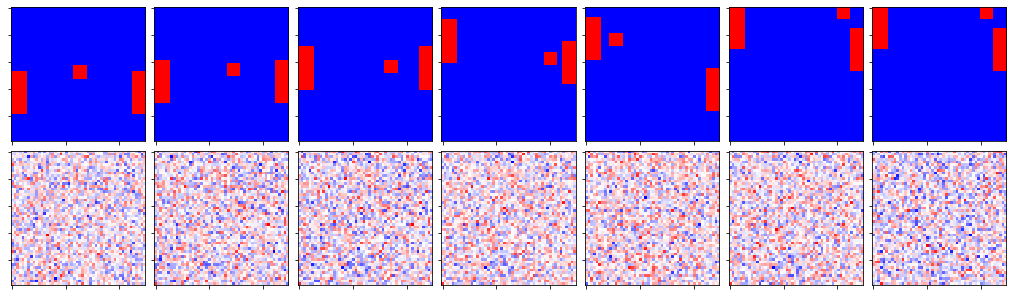

In [21]:
frame_nums = [1, 5, 10, 20, 50, 100, 120]
plot_pairwise_frames(frame_nums)

In [22]:
input_generator = make_dataset(bs=128)

model.fit_generator(
    generator=input_generator,
    validation_data=input_generator,
    validation_steps=10,
    steps_per_epoch=100,
    epochs=200
)

Epoch 1/200
100/100 [==============================] - 196s 2s/step - loss: 0.4937 - tf_op_layer_frames_1_loss: 0.3121 - tf_op_layer_game_over_1_loss: 0.1816 - tf_op_layer_frames_1_acc: 0.9143 - tf_op_layer_game_over_1_acc: 0.9629 - val_loss: 0.3087 - val_tf_op_layer_frames_1_loss: 0.1996 - val_tf_op_layer_game_over_1_loss: 0.1092 - val_tf_op_layer_frames_1_acc: 0.9213 - val_tf_op_layer_game_over_1_acc: 0.9607
Epoch 2/200
100/100 [==============================] - 191s 2s/step - loss: 0.1852 - tf_op_layer_frames_1_loss: 0.1518 - tf_op_layer_game_over_1_loss: 0.0334 - tf_op_layer_frames_1_acc: 0.9420 - tf_op_layer_game_over_1_acc: 0.9875 - val_loss: 0.1626 - val_tf_op_layer_frames_1_loss: 0.1397 - val_tf_op_layer_game_over_1_loss: 0.0229 - val_tf_op_layer_frames_1_acc: 0.9470 - val_tf_op_layer_game_over_1_acc: 0.9886
Epoch 4/200
100/100 [==============================] - 190s 2s/step - loss: 0.1609 - tf_op_layer_frames_1_loss: 0.1314 - tf_op_layer_game_over_1_loss: 0.0295 - tf_op_layer_

Epoch 22/200
100/100 [==============================] - 190s 2s/step - loss: 0.5937 - tf_op_layer_frames_1_loss: 0.0383 - tf_op_layer_game_over_1_loss: 0.5554 - tf_op_layer_frames_1_acc: 0.9859 - tf_op_layer_game_over_1_acc: 0.9640 - val_loss: 0.6010 - val_tf_op_layer_frames_1_loss: 0.0380 - val_tf_op_layer_game_over_1_loss: 0.5630 - val_tf_op_layer_frames_1_acc: 0.9861 - val_tf_op_layer_game_over_1_acc: 0.9635
Epoch 23/200
100/100 [==============================] - 190s 2s/step - loss: 0.5954 - tf_op_layer_frames_1_loss: 0.0370 - tf_op_layer_game_over_1_loss: 0.5585 - tf_op_layer_frames_1_acc: 0.9863 - tf_op_layer_game_over_1_acc: 0.9638 - val_loss: 0.6124 - val_tf_op_layer_frames_1_loss: 0.0372 - val_tf_op_layer_game_over_1_loss: 0.5752 - val_tf_op_layer_frames_1_acc: 0.9861 - val_tf_op_layer_game_over_1_acc: 0.9627
Epoch 24/200
100/100 [==============================] - 190s 2s/step - loss: 0.6182 - tf_op_layer_frames_1_loss: 0.0432 - tf_op_layer_game_over_1_loss: 0.5750 - tf_op_lay

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



100/100 [==============================] - 191s 2s/step - loss: 0.3784 - tf_op_layer_frames_1_loss: 0.0384 - tf_op_layer_game_over_1_loss: 0.3400 - tf_op_layer_frames_1_acc: 0.9863 - tf_op_layer_game_over_1_acc: 0.9768 - val_loss: 0.4108 - val_tf_op_layer_frames_1_loss: 0.0358 - val_tf_op_layer_game_over_1_loss: 0.3750 - val_tf_op_layer_frames_1_acc: 0.9869 - val_tf_op_layer_game_over_1_acc: 0.9747
Epoch 116/200
 11/100 [==>...........................] - ETA: 2:42 - loss: 0.3835 - tf_op_layer_frames_1_loss: 0.0356 - tf_op_layer_game_over_1_loss: 0.3479 - tf_op_layer_frames_1_acc: 0.9870 - tf_op_layer_game_over_1_acc: 0.9765

KeyboardInterrupt: 

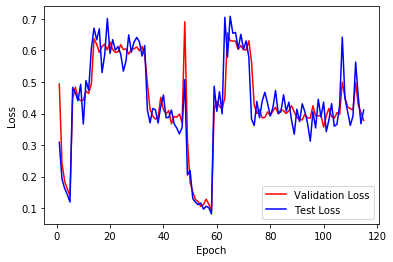

In [23]:
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r')
plt.plot(epoch_count, test_loss, 'b')
plt.legend(['Validation Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

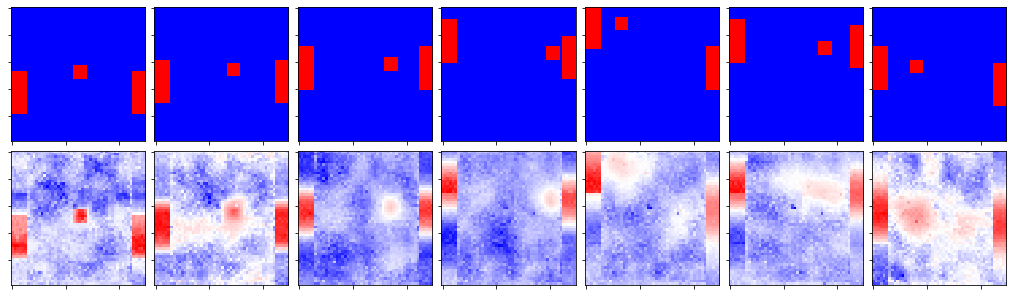

In [24]:
plot_pairwise_frames(frame_nums)

In [27]:
model.save('LSTM3_PONG.hdf5')

TypeError: ('Not JSON Serializable:', b'\n\x08frames_1\x12\x07Reshape\x1a\x10dense_2/Identity\x1a\x0eframes_1/shape*\x07\n\x01T\x12\x020\x01*\x0c\n\x06Tshape\x12\x020\x03')

In [29]:
tf.saved_model.save(model, 'LSTM3_PONG_2.hdf5')